In [1]:
!pip install kaggle --quiet
!pip install torchinfo --quiet

In [2]:
#### Install necessary library
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange
from pathlib import Path
import os
import random
import time


In [3]:
#### download dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nunenuh/pytorch-challange-flower-dataset")

print("Path to dataset files:", path)

100%|██████████| 330M/330M [00:07<00:00, 46.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nunenuh/pytorch-challange-flower-dataset/versions/3


In [4]:
train_dir = f'{path}/dataset/train'
valid_dir = f'{path}/dataset/valid'
test_dir = f'{path}/dataset/test'
cat_to_name = f'{path}/cat_to_name.json'

In [5]:
# create a temporary dataloader to find stats of datasets to normalize the images
def getStats(
    data_dir,
    image_size=((228, 228)),
    batch_size=16
    ):

  # Define basic transforms (resize and covert into tensor)
  transform = transforms.Compose([
      transforms.Resize((228, 228)),
      transforms.ToTensor()
  ])

  # load the datasets
  dataset = datasets.ImageFolder(
      data_dir,
      transform=transform
  )

  # creat loader
  loader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=True
  )

  mean = 0.0
  std = 0.0
  total_images = 0

  print('Calculating mean and std----')
  for images, _ in tqdm(loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples


  mean /= total_images
  std /= total_images

  return mean, std

mean, std = getStats(train_dir)

Calculating mean and std----


  0%|          | 0/410 [00:00<?, ?it/s]

In [6]:
# create data loader and augmentation

def get_data_augmentation(image_size):
  """
  data augmentation
  """
  train_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


  val_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

  return train_transforms, val_transforms

def load_data(
    train_dir,
    val_dir,
    batch_size,
    image_size=((228, 228))):

    train_transforms, val_transforms = get_data_augmentation(image_size)

    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_data = datasets.ImageFolder(val_dir, transform=val_transforms)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True)

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False
    )

    classes = train_data.classes

    return train_loader, val_loader, classes

In [7]:
train_loader, val_loader, classes = load_data(train_dir,
                                              valid_dir,
                                              batch_size=32,
                                              image_size=((228, 228)))

In [8]:
print(f"we have total {len(classes)} classes")

we have total 102 classes


In [9]:
# distribution of datasets
from collections import Counter
train_class_count = Counter([label for _, label in train_loader.dataset])
val_class_count = Counter([label for _, label in val_loader.dataset])

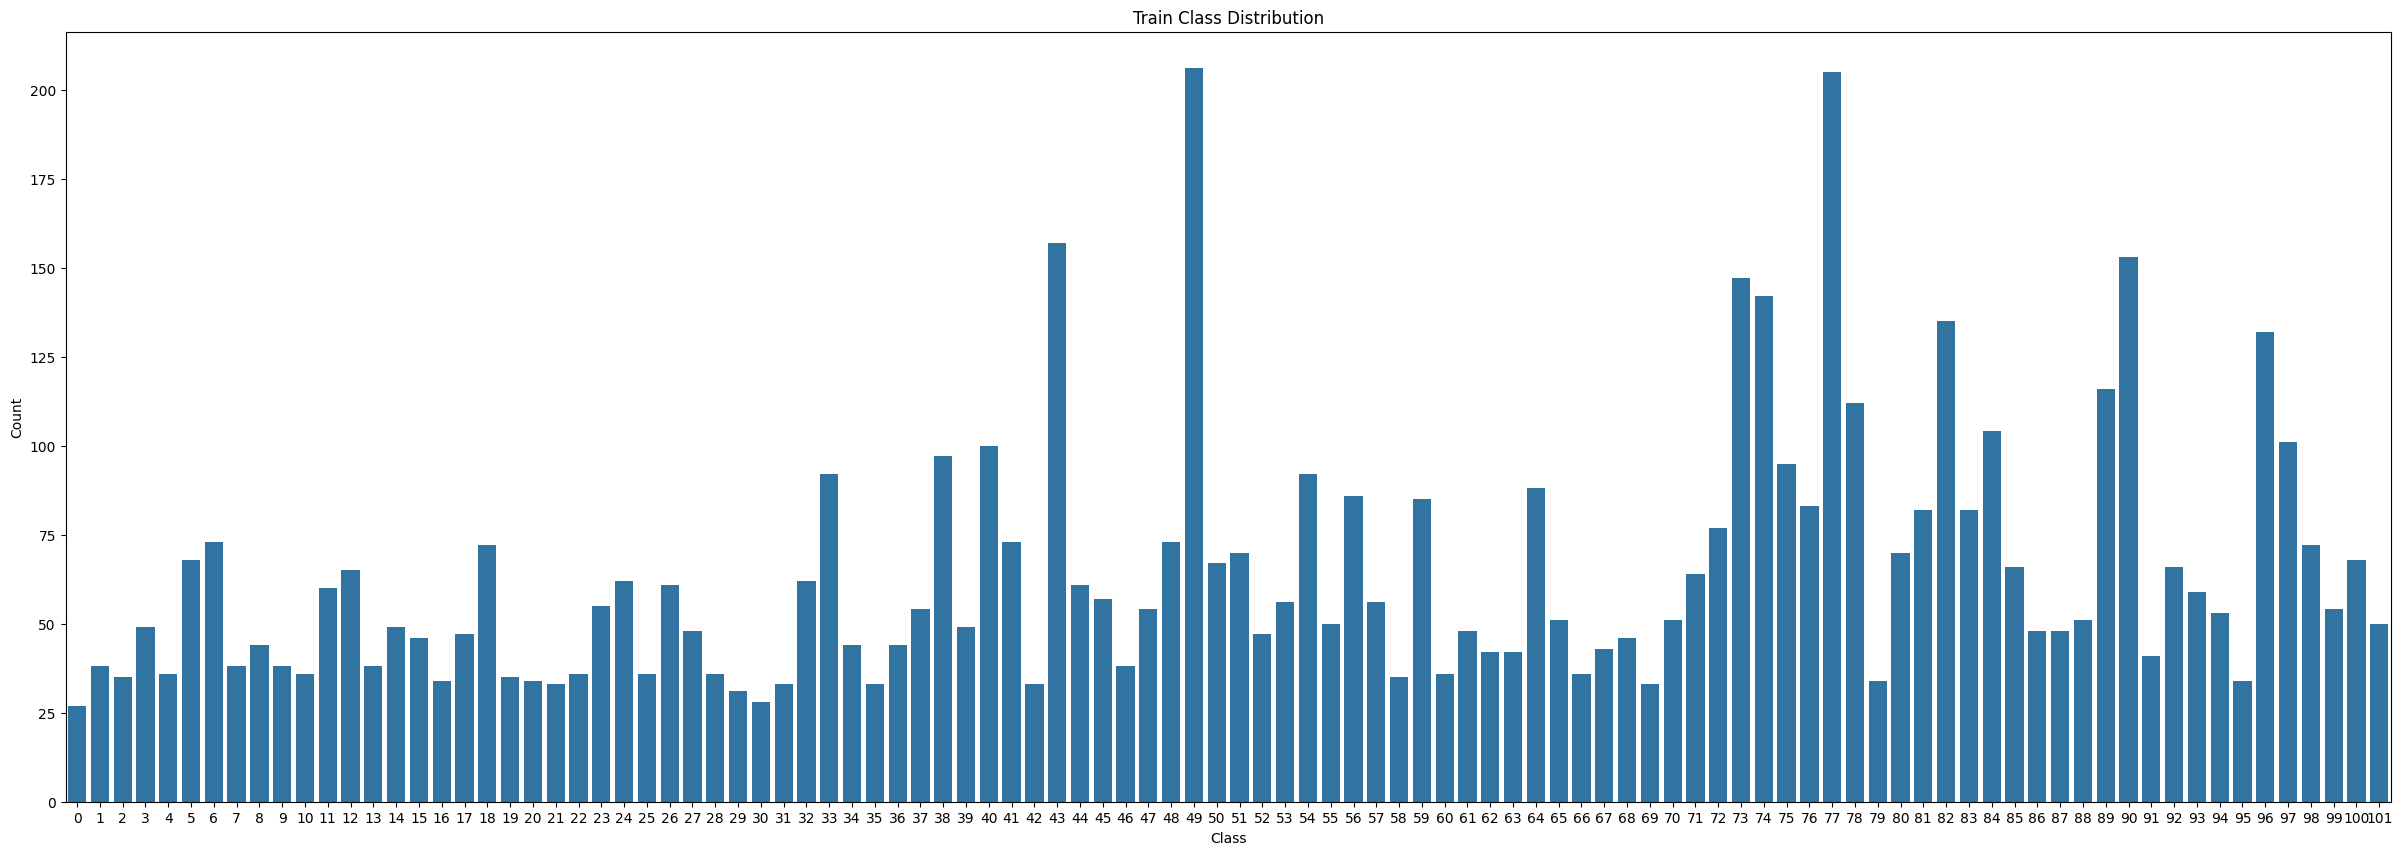

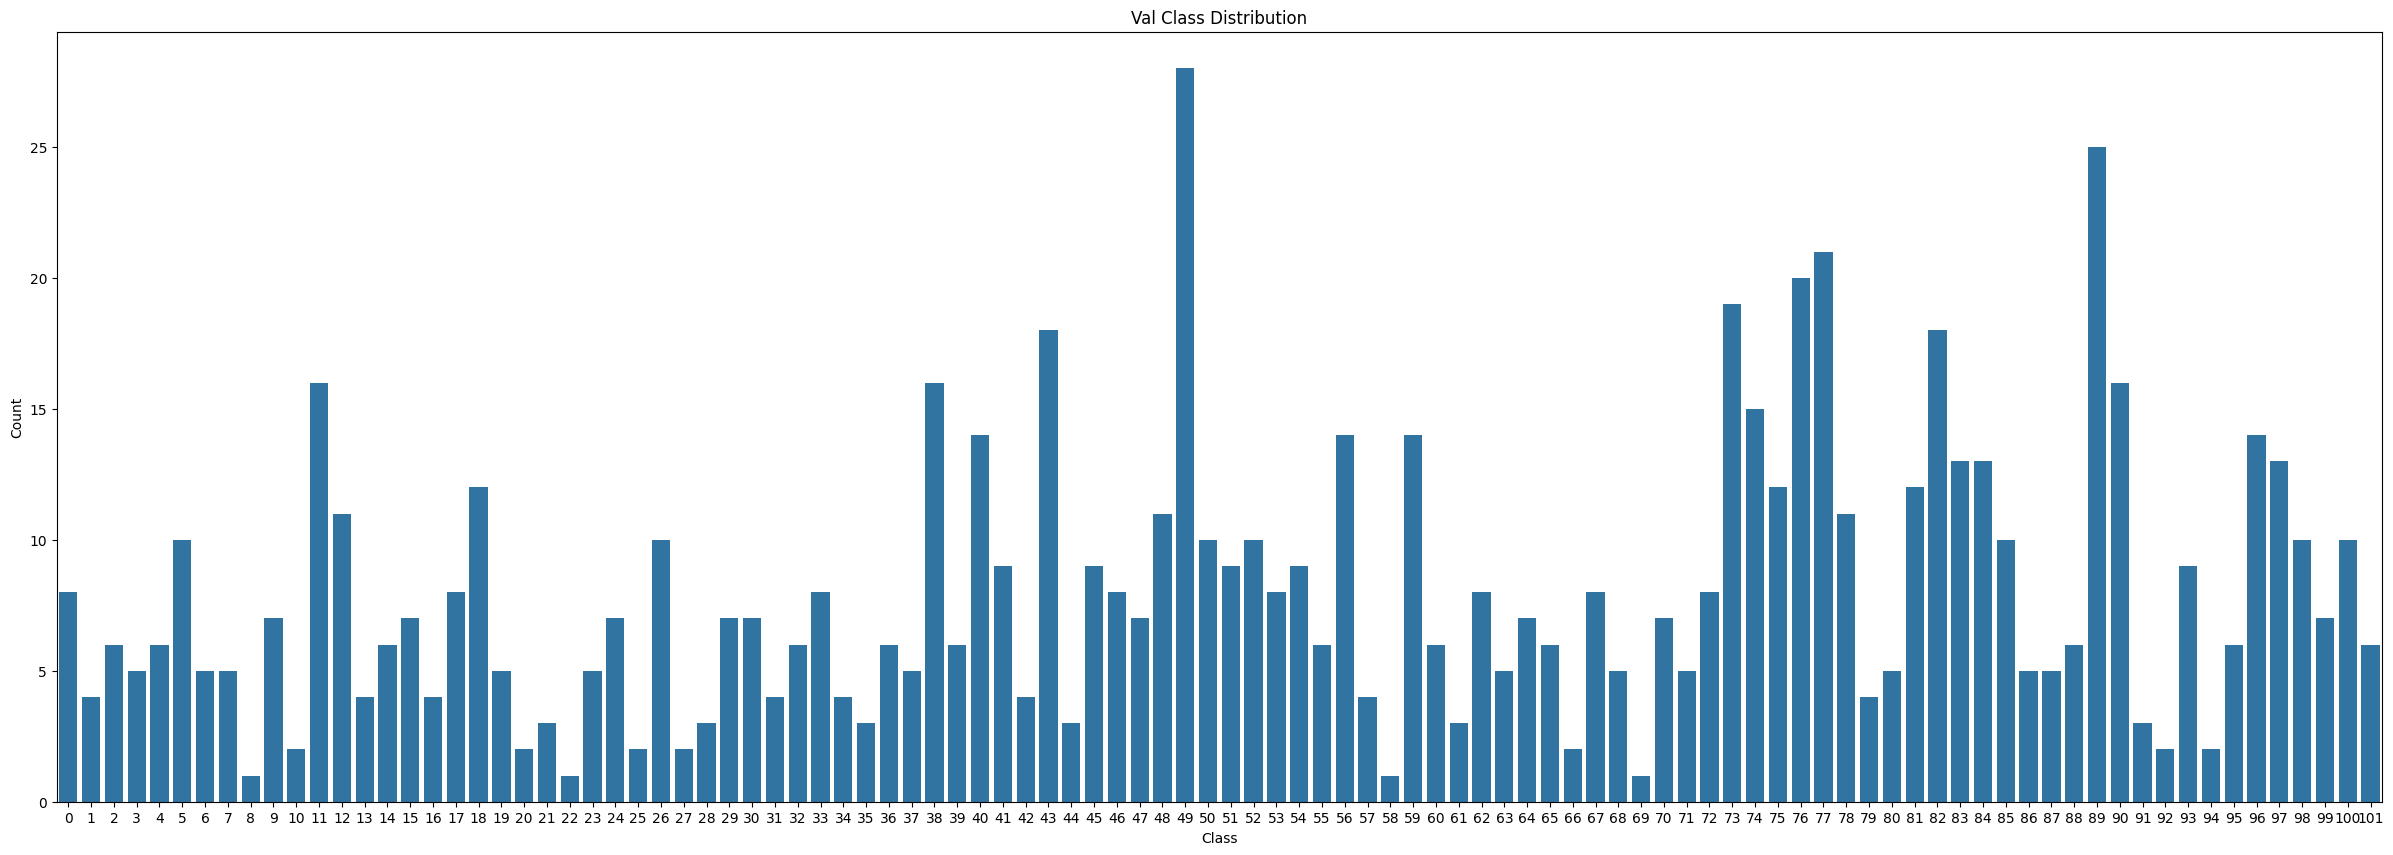

In [10]:
import seaborn as sns

plt.figure(figsize=(30, 10))
sns.barplot(x=train_class_count.keys(), y=train_class_count.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Class Distribution')
plt.show()


plt.figure(figsize=(30, 10))
sns.barplot(x=val_class_count.keys(), y=val_class_count.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Val Class Distribution')
plt.show()

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class FlowerClassifier(nn.Module):

    def __init__(self, input_size, num_of_classes):
        super(FlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make__layer(64, 64, 2, stride=1)
        self.layer2 = self._make__layer(64, 128, 2, stride=2)
        self.layer3 = self._make__layer(128, 256, 2, stride=2)
        self.layer4 = self._make__layer(256, 512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_of_classes)

    def _make__layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [12]:
Input_size = (228, 228)
num_of_classes = len(classes)

with torch.no_grad():
  model = FlowerClassifier(Input_size, num_of_classes)

In [13]:
summary(model)

Layer (type:depth-idx)                   Param #
FlowerClassifier                         --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Sequential: 3-5              --
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─Conv2d: 3-8                  36,864
│    │    └─BatchNorm2d: 3-9             128
│    │    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728
│    │    └─BatchNorm2d: 3-12            256
│    │    └─Conv2d: 3-13                 1

In [26]:
class Earlystopping:
  def __init__(self, patience=5, delta=0, path="checkpoint.pt", verbose=False):

    self.patience = patience
    self.path = path
    self.delta = delta
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = float('inf')

  def __call__(self, val_loss, model):
    score = val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)

    elif score > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Earlystopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = val_loss
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    """save model when validation loss decrease"""
    if self.verbose:
      print(f"Validation loss decrease {self.val_loss_min:.6f} ----> {val_loss:.6f}")
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

In [27]:
def model_training(model,
                   train_loader,
                   val_loader,
                   criterion,
                   optimizer,
                   epochs,
                   device,
                   checkpoint_dir="checkpoints",
                   patience=5,
                   delta=0,
                   scheduler=None
):

  model.to(device)

  Path(checkpoint_dir).mkdir(exist_ok=True)

  # Initialize early stopping object
  early_stopping = Earlystopping(patience=patience, delta=delta, path=f"{checkpoint_dir}/best_model.pt")

  history = {
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': []
  }

  best_val_loss = float('inf')

  # Training phase
  for epoch in range(epochs):

    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_pbar = tqdm(train_loader, desc = f"Epoch {epoch + 1} Training")

    for batch, (inputs, targets) in enumerate(train_pbar):
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward pass
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      train_total += targets.size(0)
      train_correct += targets.eq(predicted).sum().item()

      # update the progress bar

      avg_loss = train_loss / (batch + 1)
      acc = 100. * train_correct / train_total
      train_pbar.set_postfix({
          "Loss": f"{avg_loss:.4f}",
          "Acc": f"{acc:.2f}%"
      })

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100. * train_correct / train_total

    history['train_acc'].append(epoch_train_acc)
    history['train_loss'].append(epoch_train_loss)


  # validation phase

    model.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0


    with torch.no_grad():
      val_pbar = tqdm(val_loader, desc = f"Epoch {epoch + 1} Validation")

      for batch, (inputs, targets) in enumerate(val_pbar):
        inputs, targets = inputs.to(device), targets.to(device)


        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        val_loss += loss.item()

        _, predicted = outputs.max(1)
        val_total += targets.size(0)
        val_correct += targets.eq(predicted).sum().item()

        # update the progress bar

        avg_loss = val_loss / (batch + 1)
        acc = 100. * val_correct / val_total
        val_pbar.set_postfix({
            "Loss": f"{avg_loss:.4f}",
            "Acc": f"{acc:.2f}%"
        })

      epoch_val_loss = val_loss / len(val_loader)
      epoch_val_acc = 100. * val_correct / val_total

      history['val_acc'].append(epoch_val_acc)
      history['val_loss'].append(epoch_val_loss)


      if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'val_acc': epoch_val_acc,
            'val_loss': epoch_val_loss

        }, f"{checkpoint_dir}/best_model_acc.pt")

      # update scheduler
      if scheduler:
        scheduler.step(epoch_val_loss)

      early_stopping(epoch_val_loss, model)
      if early_stopping.early_stop:
        print(f"Early stop triggered at epoch {epoch + 1}")
        break


  return history

In [31]:
def setup_training(
    model,
    train_loader,
    val_loader,
    epoch=10,
    patience=5,
    delta=0,
    lr=1e-4,
    weight_decay=0.01):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  scheduler = ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-6, verbose=True)

  history = model_training(model, train_loader, val_loader, criterion, optimizer, epoch, device=device, scheduler=scheduler)

  return history


In [32]:
history = setup_training(model, train_loader, val_loader, 20)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 13 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 14 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 15 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 16 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 17 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 18 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 19 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20 Training:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/26 [00:00<?, ?it/s]

### Train upto 50 epoch we will get Nice Accuracy